In [1]:
import numpy as np
import pandas as pd
from os import path
import matplotlib.pyplot as plt
from tqdm import tqdm
import umap
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
DATA_DIR = "../../data"

In [3]:
chen_data = pd.read_csv(path.join(DATA_DIR, "chen/deduplicated/chen_data.csv"), index_col=0)
chen_data

,Antibody_ID,heavy,light,Y
0,12e8,EVQLQQSGAEVVRSGASVKLSCTASGFNIKDYYIHWVKQRPEKGLE...,DIVMTQSQKFMSTSVGDRVSITCKASQNVGTAVAWYQQKPGQSPKL...,0
1,15c8,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQKPEQGLE...,DIVLTQSPAIMSASLGERVTMTCTASSSVSSSNLHWYQQKPGSSPK...,0
2,1a0q,EVQLQESDAELVKPGASVKISCKASGYTFTDHVIHWVKQKPEQGLE...,DIELTQSPSSLSASLGGKVTITCKASQDIKKYIGWYQHKPGKQPRL...,1
3,1a14,QVQLQQSGAELVKPGASVRMSCKASGYTFTNYNMYWVKQSPGQGLE...,DIELTQTTSSLSASLGDRVTISCRASQDISNYLNWYQQNPDGTVKL...,0
4,1a2y,QVQLQESGPGLVAPSQSLSITCTVSGFSLTGYGVNWVRQPPGKGLE...,DIVLTQSPASLSASVGETVTITCRASGNIHNYLAWYQQKQGKSPQL...,0
...,...,...,...,...
2404,6s5a,EVKLLESGGGLVQPGGSLKLSCAASGFDFSRYWMNWVRQAPGKGLE...,QAVVTQESALTTSPGETVTLTCRSSTGAVTTSNYANWVQEKPDHLF...,0
2405,6tyb,EVQLVQSGTEVKRPGESLTISCKTSGYSFSGTWISWVRQMPGKGLE...,DIQMTQSPSSLSASVGDRVTITCRASQGISTYLAWYQQKPGKAPKL...,0
2406,6u1t,EVQLVESGGGLVKPGGSLKLSCAASGFTFSSYDMSWVRQTPEKRLE...,DIQMTQSPASQSASLGESVTITCLASQTIGTWLAWYQQKPGKSPQL...,0
2407,7fab,AVQLEQSGPGLVRPSQTLSLTCTVSGTSFDDYYWTWVRQPPGRGLE...,ASVLTQPPSVSGAPGQRVTISCTGSSSNIGAGHNVKWYQQLPGTAP...,0


# Load precomputed ANARCI matrix

In [73]:
heavy_df = pd.read_csv(path.join(DATA_DIR, "chen/abnumber/chen_heavy_chain_numbering.csv"), index_col=0)
light_df = pd.read_csv(path.join(DATA_DIR, "chen/abnumber/chen_light_chain_numbering.csv"), index_col=0)
heavy_df.head()

,Ab_ID,species,chain_type,1,2,3,3A,4,4A,5,...,119,120,121,122,123,124,125,126,127,128
0,12e8,mouse,H,E,V,Q,-,L,-,Q,...,G,Q,G,T,L,V,T,V,S,A
1,15c8,mouse,H,E,V,Q,-,L,-,Q,...,G,Q,G,T,T,L,T,V,S,S
2,1a0q,mouse,H,E,V,Q,-,L,-,Q,...,G,Q,G,T,T,L,T,V,S,S
3,1a14,mouse,H,Q,V,Q,-,L,-,Q,...,G,Q,G,T,T,V,T,V,-,-
4,1a2y,mouse,H,Q,V,Q,-,L,-,Q,...,G,Q,G,T,T,L,T,V,S,S


In [76]:
heavy_df.loc[1921] = [np.nan] * 207
heavy_df.loc[2097] = [np.nan] * 207

In [77]:
heavy_df = heavy_df.loc[chen_data.index]
light_df = light_df.loc[chen_data.index]
len(heavy_df)

1577

In [93]:
len(light_df)

1577

In [5]:
def anarci_similarity_matrix(anarci_df):
    pos_columns = [col for col in anarci_df.columns if col[0].isnumeric()]
    positions = anarci_df[pos_columns]
    tasks = [(row, positions) for i, row in positions.iterrows()]
    rows = tqdm(map(identity_task, tasks), total=len(tasks), position=0, leave=True)
    matrix = pd.DataFrame(rows)
    matrix.index = matrix.columns
    return matrix

def identity_task(task):
    seq, seqs = task
    return seqs.apply(all_position_identity, seq2=seq, axis=1).astype(np.float16)

def all_position_identity(seq1, seq2):
    return (seq1 == seq2).mean()

# Compute similarity matrices

In [79]:
heavy_similarity = anarci_similarity_matrix(heavy_df)
heavy_similarity.head()

100%|██████████| 1577/1577 [09:22<00:00,  2.80it/s]


,0,1,2,3,4,5,7,8,9,10,...,2398,2400,2401,2402,2403,2404,2405,2406,2407,2408
0,1.000000,0.857910,0.784180,0.769531,0.656738,0.759766,0.686035,0.686035,0.818848,0.754883,...,0.598145,0.691406,0.745117,0.686035,0.691406,0.710938,0.696289,0.720703,0.691406,0.691406
1,0.857910,1.000000,0.818848,0.789062,0.676270,0.774414,0.681152,0.681152,0.857910,0.784180,...,0.598145,0.696289,0.750000,0.696289,0.706055,0.686035,0.671387,0.715820,0.691406,0.691406
2,0.784180,0.818848,1.000000,0.818848,0.676270,0.813965,0.725586,0.725586,0.793945,0.803711,...,0.583496,0.681152,0.750000,0.691406,0.706055,0.676270,0.676270,0.696289,0.637207,0.666504
3,0.769531,0.789062,0.818848,1.000000,0.656738,0.808594,0.701172,0.701172,0.793945,0.803711,...,0.598145,0.701172,0.759766,0.715820,0.740234,0.671387,0.686035,0.691406,0.656738,0.691406
4,0.656738,0.676270,0.676270,0.656738,1.000000,0.666504,0.686035,0.686035,0.676270,0.701172,...,0.720703,0.725586,0.661621,0.656738,0.656738,0.696289,0.651855,0.706055,0.720703,0.706055


In [80]:
heavy_similarity.to_csv(path.join(DATA_DIR, "chen/distances/deduplicated_anarci_similarity_heavy.csv"))

In [4]:
heavy_similarity = pd.read_csv(path.join(DATA_DIR, "chen/distances/deduplicated_anarci_similarity_heavy.csv"), index_col=0)

In [83]:
light_similarity = anarci_similarity_matrix(light_df)
light_similarity.head()

100%|██████████| 1577/1577 [08:48<00:00,  2.99it/s]


,0,1,2,3,4,5,7,8,9,10,...,2398,2400,2401,2402,2403,2404,2405,2406,2407,2408
0,1.000000,0.695801,0.623047,0.630371,0.645020,0.586914,0.652344,0.652344,0.703125,0.681152,...,0.586914,0.572266,0.558105,0.550781,0.709961,0.500000,0.384033,0.688477,0.528809,0.565430
1,0.695801,1.000000,0.681152,0.681152,0.709961,0.630371,0.630371,0.630371,0.637695,0.811523,...,0.594238,0.608887,0.594238,0.565430,0.681152,0.528809,0.434814,0.717285,0.586914,0.572266
2,0.623047,0.681152,1.000000,0.703125,0.709961,0.565430,0.565430,0.565430,0.623047,0.637695,...,0.536133,0.528809,0.550781,0.550781,0.681152,0.500000,0.434814,0.703125,0.514648,0.550781
3,0.630371,0.681152,0.703125,1.000000,0.666504,0.565430,0.608887,0.608887,0.572266,0.623047,...,0.558105,0.572266,0.558105,0.521973,0.673828,0.514648,0.413086,0.652344,0.507324,0.536133
4,0.645020,0.709961,0.709961,0.666504,1.000000,0.594238,0.594238,0.594238,0.623047,0.666504,...,0.528809,0.558105,0.543457,0.543457,0.703125,0.543457,0.434814,0.818848,0.521973,0.565430


In [84]:
light_similarity.to_csv(path.join(DATA_DIR, "chen/distances/deduplicated_anarci_similarity_light.csv"))

In [5]:
light_similarity = pd.read_csv(path.join(DATA_DIR, "chen/distances/deduplicated_anarci_similarity_light.csv"), index_col=0)


In [6]:
def fit_umap(df, n_components=2, random_state=0, **kwargs):
    reducer = umap.UMAP(n_components=n_components, random_state=random_state, metric='precomputed', **kwargs)
    embedding = reducer.fit_transform(df)
    return reducer, pd.DataFrame(embedding, columns=[f'UMAP-{i+1}' for i in range(n_components)], index=df.index)

In [7]:
def agglomerative_clustering(distance, linkage='complete', **kwargs):
    clusters = AgglomerativeClustering(linkage=linkage, affinity='precomputed', **kwargs).fit(distance).labels_
    return pd.Series(clusters+1, distance.index)

## Combine heavy and light distances

In [6]:
similarity = (light_similarity + heavy_similarity) / 2
similarity

,0,1,2,3,4,5,7,8,9,10,...,2398,2400,2401,2402,2403,2404,2405,2406,2407,2408
0,1.00000,0.77700,0.70350,0.69995,0.65085,0.67350,0.66915,0.66915,0.76100,0.71800,...,0.59250,0.63185,0.65150,0.61850,0.70070,0.60550,0.54015,0.70460,0.61020,0.62840
1,0.77700,1.00000,0.75000,0.73500,0.69315,0.70240,0.65570,0.65570,0.74785,0.79775,...,0.59600,0.65265,0.67200,0.63085,0.69350,0.60750,0.55310,0.71665,0.63920,0.63185
2,0.70350,0.75000,1.00000,0.76100,0.69315,0.68970,0.64550,0.64550,0.70850,0.72070,...,0.55975,0.60500,0.65050,0.62120,0.69350,0.58815,0.55555,0.69965,0.57580,0.60875
3,0.69995,0.73500,0.76100,1.00000,0.66160,0.68700,0.65500,0.65500,0.68315,0.71335,...,0.57800,0.63665,0.65900,0.61900,0.70700,0.59300,0.54950,0.67185,0.58200,0.61370
4,0.65085,0.69315,0.69315,0.66160,1.00000,0.63025,0.64000,0.64000,0.64965,0.68375,...,0.62485,0.64180,0.60255,0.60010,0.67985,0.61990,0.54340,0.76250,0.62135,0.63570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2404,0.60550,0.60750,0.58815,0.59300,0.61990,0.57125,0.58580,0.58215,0.62010,0.61370,...,0.57700,0.67600,0.64515,0.59425,0.55885,1.00000,0.47705,0.67160,0.59425,0.64800
2405,0.54015,0.55310,0.55555,0.54950,0.54340,0.51600,0.50235,0.50235,0.52050,0.52650,...,0.46710,0.51125,0.52465,0.51610,0.57275,0.47705,1.00000,0.56310,0.48175,0.51360
2406,0.70460,0.71665,0.69965,0.67185,0.76250,0.66085,0.65720,0.65720,0.70000,0.67895,...,0.57575,0.69715,0.62350,0.61500,0.70165,0.67160,0.56310,1.00000,0.59425,0.68700
2407,0.61020,0.63920,0.57580,0.58200,0.62135,0.58095,0.55650,0.55650,0.59545,0.60990,...,0.64600,0.71015,0.69680,0.62065,0.59650,0.59425,0.48175,0.59425,1.00000,0.64020


In [7]:
similarity.to_csv(path.join(DATA_DIR, "chen/distances/deduplicated_anarci_similarity.csv"))

In [4]:
similarity = pd.read_csv(path.join(DATA_DIR, "chen/distances/deduplicated_anarci_similarity.csv"), index_col=0)
similarity.head()

,0,1,2,3,4,5,7,8,9,10,...,2398,2400,2401,2402,2403,2404,2405,2406,2407,2408
0,1.00000,0.77700,0.70350,0.69995,0.65085,0.67350,0.66915,0.66915,0.76100,0.71800,...,0.59250,0.63185,0.65150,0.61850,0.70070,0.60550,0.54015,0.70460,0.61020,0.62840
1,0.77700,1.00000,0.75000,0.73500,0.69315,0.70240,0.65570,0.65570,0.74785,0.79775,...,0.59600,0.65265,0.67200,0.63085,0.69350,0.60750,0.55310,0.71665,0.63920,0.63185
2,0.70350,0.75000,1.00000,0.76100,0.69315,0.68970,0.64550,0.64550,0.70850,0.72070,...,0.55975,0.60500,0.65050,0.62120,0.69350,0.58815,0.55555,0.69965,0.57580,0.60875
3,0.69995,0.73500,0.76100,1.00000,0.66160,0.68700,0.65500,0.65500,0.68315,0.71335,...,0.57800,0.63665,0.65900,0.61900,0.70700,0.59300,0.54950,0.67185,0.58200,0.61370
4,0.65085,0.69315,0.69315,0.66160,1.00000,0.63025,0.64000,0.64000,0.64965,0.68375,...,0.62485,0.64180,0.60255,0.60010,0.67985,0.61990,0.54340,0.76250,0.62135,0.63570


In [9]:
similarity[similarity.isna().all(axis=1)]

,0,1,2,3,4,5,7,8,9,10,...,2398,2400,2401,2402,2403,2404,2405,2406,2407,2408


In [10]:
reducer, hl_umap = fit_umap(1-similarity, n_neighbors=10)
hl_umap.head()

/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "


,UMAP-1,UMAP-2
0,5.175946,5.573149
1,2.589075,1.607183
2,9.610127,5.456150
3,9.755935,6.119452
4,7.625130,4.040932


# Cluster sequences and plot

In [8]:
def plot_clustering(similarity_mat, n_clusters, dist_thresh, umap_coords, linkage="single"):
    clusters = agglomerative_clustering(
        1-similarity_mat, 
        n_clusters=n_clusters, 
        
        distance_threshold=dist_thresh, 
        linkage=linkage
    )
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax = sns.scatterplot(
        data=umap_coords,
        x='UMAP-1',
        y='UMAP-2',
        hue=clusters,
        palette='tab20',
        ax=ax,
        legend=False,
    )
    fig.show()
    return clusters

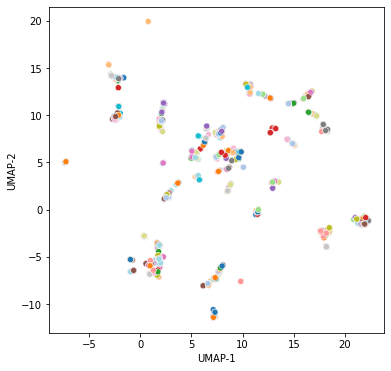

In [29]:
clusters = plot_clustering(similarity, None, 0.05, hl_umap)

In [30]:
clusters.max()

1225

Most clusters only contain 1 sequence.

## Sanity check
If two sequences ave at least 95% similarity, they should be in the same cluster.

In [31]:
def similar_sequences(seq_row, index, threshold=0.95):
    selected = seq_row[seq_row > threshold].index
    for other in selected:
        if clusters[index] != clusters[int(other)]:
            return False
    return True

In [32]:
checked = similarity.apply(lambda x: similar_sequences(x, x.name), axis=1)

In [33]:
checked.sum()

1577

## Clustering with a lower threshold

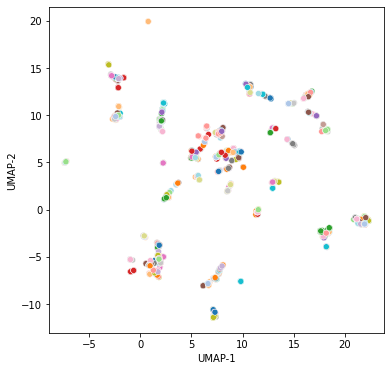

In [11]:
clusters = plot_clustering(similarity, None, 0.1, hl_umap)

In [12]:
clusters.max()

939

There are fewer clusters here, still average size is below 2. Let's use this clustering.
## Define datasets using clustering

In [13]:
cluster_assignment = {}
for i, cl in enumerate(clusters):
    cluster_assignment[cl] = cluster_assignment.get(cl, []) + [i]

In [14]:
train_indices, test_indices = train_test_split(range(clusters.max()), test_size=0.2, random_state=42)

In [15]:
test_indices, valid_indices = train_test_split(test_indices, test_size=0.5, random_state=46)

In [16]:
train_set = []
for idx in train_indices:
    train_set += cluster_assignment[idx + 1]
len(train_set)

1338

In [17]:
valid_set = []
for idx in valid_indices:
    valid_set += cluster_assignment[idx + 1]
len(valid_set)

120

In [18]:
test_set = []
for idx in test_indices:
    test_set += cluster_assignment[idx + 1]
len(test_set)

119

In [42]:
chen_train = chen_data.iloc[train_set]
chen_train

,Antibody_ID,heavy,light,Y
2073,6aod,EVQLVQSGAEVKKPGASVKVSCKASGYTFTGYYMHWVRQAPGQGLE...,DIVMTKSPSSLSASVGDRVTITCRASQGIRNDLGWYQQKPGKAPKR...,0
1517,4yny,EVQLVESGGGLVQPGRSLKLSCAASGFTFSNYGMAWVRQTPTKGLE...,EFVLTQPNSVSTNLGSTVKLSCKRSTGNIGSNYVNWYQQHEGRSPT...,1
2025,5xcv,EVQLVESGGGLVQPGRSLKLSCAASGFTFSNYGMAWVRQTPTKGLE...,QFVLTQPNSVSTNLGSTVKLSCKRSTGNIGSNYVNWYQQHEGRSPT...,1
2070,6and,EVQLVESGGGLVQPGGSLRLSCAASGYEFSRSWMNWVRQAPGKGLE...,DIQMTQSPSSLSASVGDRVTITCRSSQSIVHSVGNTFLEWYQQKPG...,1
666,2xqy,QVQLQQPGAELVKPGASVKMSCKASGYSFTSYWMNWVKQRPGRGLE...,DIVLTQSPASLALSLGQRATISCRASKSVSTSGYSYMYWYQQKPGQ...,0
...,...,...,...,...
1080,4buh,EVQLVQSGAEVKKPGESLKISCKGSEYSFPNYWIAWVRQMPGKGLE...,SYELTQPPSASGTPGQRVTISCSGSSSNIGGNTVNWYQQVPGTAPR...,0
2296,6jbt,QGQLVQSGAEVKKPGASVKVSCKASGYTFTDYEMHWVRQAPIHGLE...,DVVMTQSPLSLPVTLGQPASISCRSSQSIVHSNGNTYLEWYLQKPG...,0
202,1kc5,QVKLQQSGPGLVKPSQSLSLTCTVTGYSITSDYAWNWIRQFPGNKL...,DIVLTQSPKSMSMSVGEKVTLSCKASENVDTYVSWYQQRPEQPPAL...,0
203,1kcr,QVALQESGPGLVKPSQSLSLTCTVTGYSITSDYAWNWIRQFPGNKL...,DIVLTQSPKSMSMSVGERVTLSCKASENVGTYVSWYQQKPEQSPKL...,1


In [43]:
chen_train.to_csv(path.join(DATA_DIR, "chen/deduplicated/chen_train_data.csv"))

In [20]:
chen_train = pd.read_csv(path.join(DATA_DIR, "chen/deduplicated/chen_train_data.csv"), index_col=0)

In [44]:
chen_valid = chen_data.iloc[valid_set]
chen_valid

,Antibody_ID,heavy,light,Y
2169,6ct7,EVQLVESGGGLVEPGGSLRLSCAVSGFDFEKAWMSWVRQAPGQGLQ...,SYELTQPPSVSVSPGQTARITCSGEALPMQFAHWYQQRPGKAPVIV...,0
1342,4nzu,AVSLVESGGGTVEPGSTLRLSCAASGFTFGSYAFHWVRQAPGDGLE...,DIEMTQSPSSLSASTGDKVTITCQASQDIAKFLDWYQQRPGKTPKL...,0
1728,5i8c,QEVLVQSGAEVKKPGASVKVSCRAFGYTFTGNALHWVRQAPGQGLE...,DIQLTQSPSFLSASVGDKVTITCRASQGVRNELAWYQQKPGKAPNL...,1
1729,5i8e,QEVLVQSGAEVKKPGASVKVSCRAFGYTFTGNALHWVRQAPGQGLE...,IQLTQSPSFLSASVGDKVTITCRASQGVRNELAWYQQKPGKAPNLL...,0
2114,6bb4,QVQLQQSDAELVKPGASVKISCKASGYTFTDRTIHWVKQRPEQGLE...,DVQMIQSPSSLSASLGDIVTMTCQASQDTSINLNWFQQKPGKAPKL...,0
...,...,...,...,...
1068,43c9,QVQLVESGPGLVAPSQSLSITCTVSGISLSRYNVHWVRQSPGKGLE...,DVVMTQTPSSLAMSVGQKVTMSCKSSQSLLNISNQKNYLAWYQQKP...,0
1872,5t5f,QVQMQQPGAELVKPGASVKLSCKASGYTFISYWMHWVKQRPGRGLE...,DIVMTQAAPSVPVTPGESVSISCRSSKSLLHSNGNTYLFWFLQRPG...,0
544,2gsi,VQLQQSGAELVRSGASVKLSCTASGFNIKDYYMYWVKLRPEQGLEW...,DIVLTQSPASLAVSLGQPATISCGASKSVRTSGYSYMDWNQQKPGQ...,0
611,2pcp,EVQLQQSGPELVKPGASVKMSCKASGYTFTDYYIHWNKQSHGKSLE...,DVLMTQTPLSLPVSLGDQASISCRSSQTIVHSNGNTYLEWYLQKPG...,0


In [45]:
chen_valid.to_csv(path.join(DATA_DIR, "chen/deduplicated/chen_valid_data.csv"))

In [21]:
chen_valid = pd.read_csv(path.join(DATA_DIR, "chen/deduplicated/chen_valid_data.csv"), index_col=0)

In [46]:
chen_test = chen_data.iloc[test_set]
chen_test

,Antibody_ID,heavy,light,Y
2372,6obd,EVQLVESGGGLVQPGGSLRLSCAASGFPFSNYWMNWVRQAPGKGLE...,DIVMTQTPLSLSVTPGQPASISCKSSQSLLYSNGKTYLNWVLQKPG...,0
359,1sm3,QVQLQESGGGLVQPGGSMKLSCVASGFTFSNYWMNWVRQSPEKGLE...,DIVVTQESALTTSPGETVTLTCRSSTGAVTTSNYANWVQEKPDHLF...,0
1539,5a2i,QVQLQESGGGLVQPGGSMKLSCVASGFTFSNYWMNWVRQSPEKGLE...,DIVVTQESALTTSPGETVTLTCRSSTGAVTTSNYANWVQEKPDHLF...,0
1112,4f33,EVQLQQSGPELEKPGASVKISCKASGYSFTGYTMNWVKQSHGKSLE...,DIELTQSPAIMSASPGEKVTMTCSASSSVSYMHWYQQKSGTSPKRW...,1
314,1q1j,EVQLVESGGGLVKPGGSLRLTCVASGFTFSDVWLNWVRQAPGKGLE...,QSVLTQPPSVSAAPGQKVTISCSGSSSNIGNNYVLWYQQFPGTAPK...,0
...,...,...,...,...
545,2h1p,DVKLVESGGGLVKLGGSLKLSCAASGFTFSSYFLSWVRQTPEKRLE...,DVVMTQTPLSLPVSLGDPASISCRSSQSLVHSNGNTYLHWYLQKPG...,0
1162,4hdi,DVKLVESGGGLVKLGGSLKLSCAASGFTFSNYFMSWVRQTPEKRLE...,DVVMTQTPLSLPVSLGDQASISCRSSQSLVHSNGNTYLHWYLQKPG...,0
2404,6s5a,EVKLLESGGGLVQPGGSLKLSCAASGFDFSRYWMNWVRQAPGKGLE...,QAVVTQESALTTSPGETVTLTCRSSTGAVTTSNYANWVQEKPDHLF...,0
1684,5gkr,QVQLQESGPGLVKSSETLSLTCTVSGGSISSYFWSWIRQPPGKGLE...,QSALTQPRSVSGSPGQSVTISCTGTSSDVGGYNYVSWYQQHPGKAP...,1


In [47]:
chen_test.to_csv(path.join(DATA_DIR, "chen/deduplicated/chen_test_data.csv"))

In [22]:
chen_test = pd.read_csv(path.join(DATA_DIR, "chen/deduplicated/chen_test_data.csv"), index_col=0)

## Check that the intersection of sets is empty

In [23]:
pd.merge(chen_train, chen_test, how='inner')

,Antibody_ID,heavy,light,Y


In [24]:
pd.merge(chen_train, chen_valid, how='inner')

,Antibody_ID,heavy,light,Y


In [25]:
pd.merge(chen_valid, chen_test, how='inner')

,Antibody_ID,heavy,light,Y


## Measure between-group similarity

In [58]:
train_valid = pd.concat([chen_valid, chen_train])

In [56]:
del(test_valid)

In [63]:
between_group_similarities = similarity.loc[train_valid.index][[str(num) for num in chen_test.index]]

In [65]:
between_group_similarities.max().max()

0.8999999999999999

In [66]:
between_group_similarities.min().min()

0.134

The maximum similarity of sequences in the train and test set is 0.89, as expected thanks to the distance cutoff of 0.1.

# Labels

In [26]:
chen_train["Y"].value_counts()

0    1057
1     281
Name: Y, dtype: int64

In [30]:
281 / (1057+281)

0.2100149476831091

In [28]:
chen_valid["Y"].value_counts()

0    94
1    26
Name: Y, dtype: int64

In [31]:
26 / (94+26)

0.21666666666666667

In [29]:
chen_test["Y"].value_counts()

0    96
1    23
Name: Y, dtype: int64

In [32]:
23 / (23+96)

0.19327731092436976